<a href="https://colab.research.google.com/github/DanielKorenDataScience/RegressionProject/blob/main/Regression%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laptop Prices prediction using Regression ML model**

# **Source link**

https://www.kaggle.com/muhammetvarl/laptop-price

# **Preliminary**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import sys
import os

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestRegressor

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

In [6]:
data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/RegressionProject/master/laptop_price.csv'
resp = requests.get(data_url)
text = resp.text

with open('laptop_price.csv', 'w') as fh:
    fh.write(text)
  
df = pd.read_csv('laptop_price.csv')

In [7]:
df = pd.read_csv('laptop_price.csv', encoding='ISO-8859–1')

# **Knowing the data**

In [8]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [9]:
df.nunique()

laptop_ID           1303
Company               19
Product              618
TypeName               6
Inches                18
ScreenResolution      40
Cpu                  118
Ram                    9
Memory                39
Gpu                  110
OpSys                  9
Weight               179
Price_euros          791
dtype: int64

In [10]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [11]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302
laptop_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
Company,Apple,Apple,HP,Apple,Apple,Acer,Apple,Apple,Asus,Acer,HP,HP,Apple,Dell,Apple,Apple,Dell,Apple,Lenovo,Dell,Asus,Lenovo,HP,Dell,HP,Dell,Apple,Dell,Dell,HP,Chuwi,Asus,HP,Dell,Apple,Lenovo,Acer,Dell,HP,HP,...,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus,Asus,Dell,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus,Asus,Dell,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus
Product,MacBook Pro,Macbook Air,250 G6,MacBook Pro,MacBook Pro,Aspire 3,MacBook Pro,Macbook Air,ZenBook UX430UN,Swift 3,250 G6,250 G6,MacBook Pro,Inspiron 3567,"MacBook 12""",MacBook Pro,Inspiron 3567,MacBook Pro,IdeaPad 320-15IKB,XPS 13,Vivobook E200HA,Legion Y520-15IKBN,255 G6,Inspiron 5379,15-BS101nv (i7-8550U/8GB/256GB/FHD/W10),Inspiron 3567,MacBook Air,Inspiron 5570,Latitude 5590,ProBook 470,"LapBook 15.6""",E402WA-GA010T (E2-6110/2GB/32GB/W10),17-ak001nv (A6-9220/4GB/500GB/Radeon,XPS 13,MacBook Air,IdeaPad 120S-14IAP,Aspire 3,Inspiron 5770,250 G6,ProBook 450,...,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10),ZenBook UX305CA-UBM1,Inspiron 3567,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10),ZenBook UX305CA-UBM1,Inspiron 3567,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10)
TypeName,Ultrabook,Ultrabook,Notebook,Ultrabook,Ultrabook,Notebook,Ultrabook,Ultrabook,Ultrabook,Ultrabook,Notebook,Notebook,Ultrabook,Notebook,Ultrabook,Ultrabook,Notebook,Ultrabook,Notebook,Ultrabook,Netbook,Gaming,Notebook,2 in 1 Convertible,Ultrabook,Notebook,Ultrabook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Ultrabook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,...,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook
Inches,13.3,13.3,15.6,15.4,13.3,15.6,15.4,13.3,14,14,15.6,15.6,15.4,15.6,12,13.3,15.6,15.4,15.6,13.3,11.6,15.6,15.6,13.3,15.6,15.6,13.3,15.6,15.6,17.3,15.6,14,17.3,13.3,13.3,14,15.6,17.3,15.6,15.6,...,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6,13.3,15.6,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6,13.3,15.6,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6
ScreenResolution,IPS Panel Retina Display 2560x1600,1440x900,Full HD 1920x1080,IPS Panel Retina Display 2880x1800,IPS Panel Retina Display 2560x1600,1366x768,IPS Panel Retina Display 2880x1800,1440x900,Full HD 1920x1080,IPS Panel Full HD 1920x1080,1366x768,Full HD 1920x1080,IPS Panel Retina Display 2880

In [12]:
df.info(null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [13]:
col = list(df.columns)
for column in col: #.split():
    print(column, ':')
#    df[column] = df[column].str.strip()
    print(df[column].value_counts())
    print()

    """ Product, Screen Resolution, CPU, Weight """

laptop_ID :
1320    1
453     1
435     1
436     1
437     1
       ..
880     1
881     1
882     1
883     1
1       1
Name: laptop_ID, Length: 1303, dtype: int64

Company :
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Vero           4
Xiaomi         4
Google         3
Fujitsu        3
Chuwi          3
LG             3
Huawei         2
Name: Company, dtype: int64

Product :
XPS 13                                        30
Inspiron 3567                                 29
250 G6                                        21
Legion Y520-15IKBN                            19
Vostro 3568                                   19
                                              ..
UX430UQ-GV209R (i7-7500U/8GB/256GB/GeForce     1
Stream 14-AX001nv                              1
GS43VR 7RE                                     1
PL60 7RD            

# Conclusions:
1. laptop_ID - Unique, not relevant to the model
2. Company - need to split category to columns
3. Product - ???
4. TypeName - need to split category to columns
5. Inches - need to make rounded
6. ScreenResolution - ???
7. Cpu - I think we should smart seperate to manufacturer and have the model in some other way !?
8. Ram - numeric
9. Memory - storage
10. Gpu - category to column !?
11. OpSys - Important -- category to columns 
12. Weight
13. Price_euros - ***Predict***

# **EDA - Data Exploration**

In [14]:
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00


In [15]:
sns.color_palette("coolwarm", as_cmap=True)
sns.set_theme(style="whitegrid")

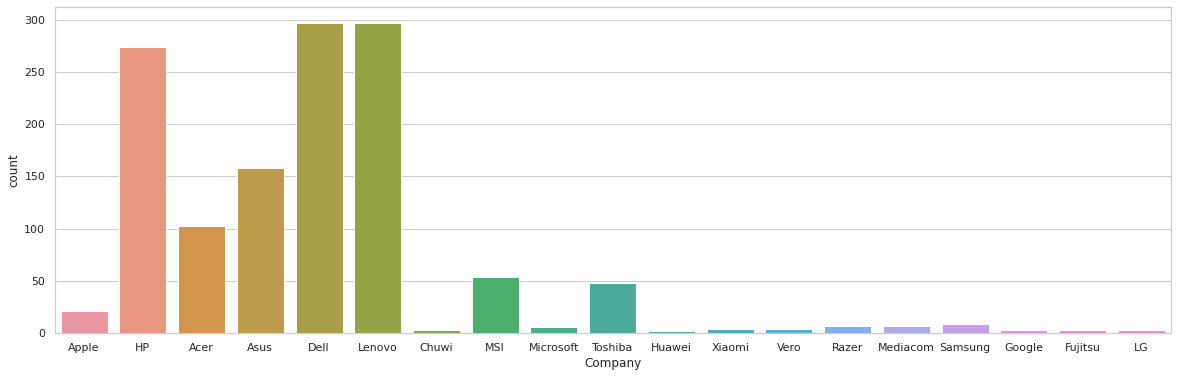

In [16]:
plt.figure(figsize=(20,6))
sns.countplot(data=df, x='Company')

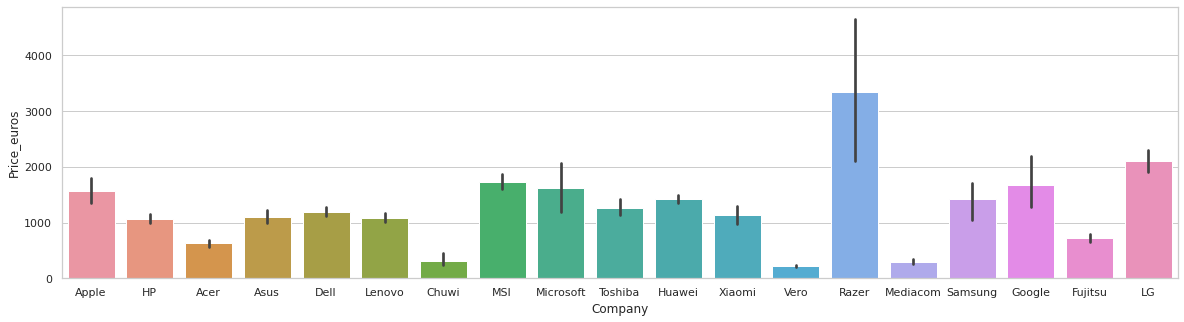

In [17]:
plt.figure(figsize=(20,5))
sns.barplot(data=df, x='Company', y=df['Price_euros'])

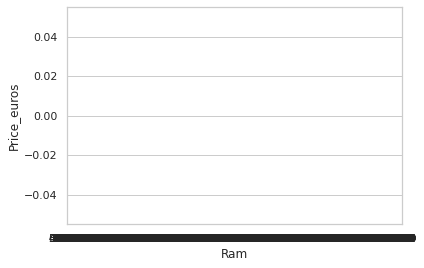

In [18]:
#plt.figure(figsize=(20,10))
df.sort_values('Price_euros', inplace=True, ascending=False)
sns.barplot(data=df, x=df['Ram'], y=df['Price_euros'], order=df.Price_euros)

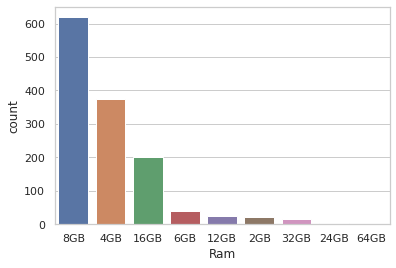

In [19]:
#plt.figure(figsize=(20,10))
sns.countplot(data=df, x='Ram', order = df['Ram'].value_counts().index)

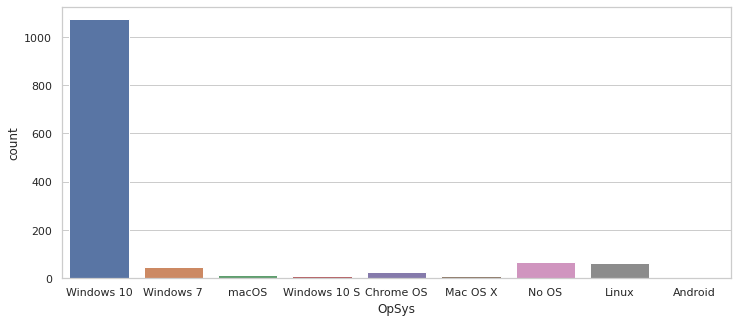

In [20]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='OpSys') #, y='Price_euros')

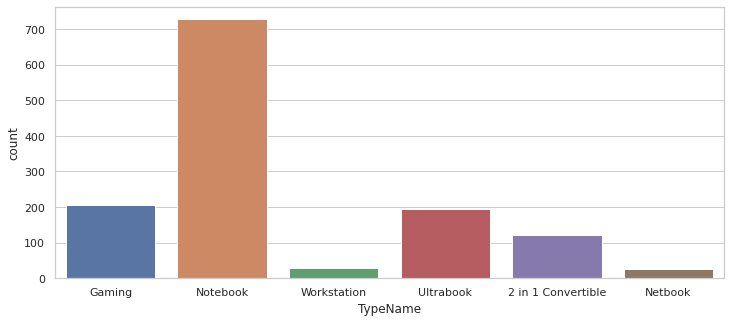

In [21]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='TypeName') #, y='Price_euros')

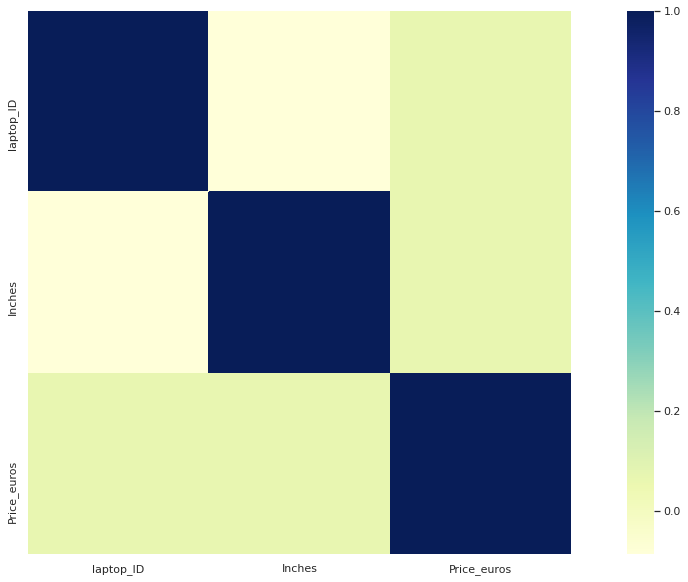

In [22]:
corr_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_df , vmax=1, square=True, annot=False, cmap='YlGnBu')

In [23]:
df.Price_euros.sort_values().tail(10)

1231    3499.0
780     3588.8
723     3659.4
238     3890.0
1136    3949.4
1066    3975.0
749     4389.0
610     4899.0
830     5499.0
196     6099.0
Name: Price_euros, dtype: float64

In [24]:
#removing noisy values - prices over 3000
df = df[df['Price_euros'] <= 3000]

# **Data Manipulation**

In [25]:
df.nunique()

laptop_ID           1284
Company               19
Product              612
TypeName               6
Inches                18
ScreenResolution      40
Cpu                  116
Ram                    8
Memory                36
Gpu                  107
OpSys                  9
Weight               178
Price_euros          772
dtype: int64

In [26]:
df.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
563,570,Lenovo,Thinkpad P71,Notebook,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M620M,Windows 10,3.4kg,2999.0
247,252,Asus,Rog G701VIK-BA060T,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7820HK 2.9GHz,16GB,256GB SSD,Nvidia GeForce GTX 1080,Windows 10,3.6kg,2999.0


In [27]:
df_Company = pd.get_dummies(df.Company, prefix='co_')
df_Product = pd.get_dummies(df.Product, prefix='prd_')
df_TypName = pd.get_dummies(df.TypeName, prefix='tpn_')
df_os = pd.get_dummies(df.OpSys, prefix='os_')

In [28]:
# Round inch information 
df.Inches = df.Inches.round()

# Ram to number
df.Ram = df.Ram.str.replace('GB','').astype(int)

# Weight to number
df.Weight = df.Weight.str.replace('kg','').astype(float)

# Memory to number
df['Storage_amt'] = df.Memory.str.split().str[0]
storage_map = {'1.0TB':'1000', '1TB':'1000', '2TB':'2000', '508':'500'}
df.Storage_amt.replace(storage_map , inplace=True)
df.Storage_amt = df.Storage_amt.str.replace('GB','').astype(int)

# Split Cpu information 
df['Cpu_brand'] = df.Cpu.str.split().str[0]
df['Cpu_speed'] = df.Cpu.str.split().str[-1]
df.Cpu_speed = df.Cpu_speed.str.split('GHz').str[0].astype(float)
#df['Cpu_model'] = 
df_Cpu_brand = pd.get_dummies(df.Cpu_brand, prefix='Cpu_')

# Split Gpu information
df['Gpu_brand'] = df.Gpu.str.split().str[0]
df_Gpu_brand = pd.get_dummies(df.Gpu_brand, prefix='Gpu_')

# Handle ScreenResolution information
df['Scr_to'] = df.ScreenResolution.str.split('x').str[-1]
df['Scr_from'] = df.ScreenResolution.str.split('x').str[0]
df['Scr_from'] = df.Scr_from.str.split().str[-1]

In [29]:
#df_Company
#df_Product
#df_TypName
#df.Inches
#df.Cpu_speed
#df_Cpu_brand

#df.Cpu_model

#df.Ram
#Storage_amt

#df.Memory

#df_os
#df.Weight

#df.Scr_to
#df.Scr_from


df_model = pd.merge(df[['Inches', 'Ram', 'Weight', 'Price_euros', 'Storage_amt', 'Cpu_speed', 'Scr_from', 'Scr_to']], df_Company, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Product, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_TypName, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_os, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Cpu_brand, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Gpu_brand, left_index=True, right_index=True)

#df.drop(['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], axis=1, inplace=True)

df_model.head(2)

,Inches,Ram,Weight,Price_euros,Storage_amt,Cpu_speed,Scr_from,Scr_to,co__Acer,co__Apple,co__Asus,co__Chuwi,co__Dell,co__Fujitsu,co__Google,co__HP,co__Huawei,co__LG,co__Lenovo,co__MSI,co__Mediacom,co__Microsoft,co__Razer,co__Samsung,co__Toshiba,co__Vero,co__Xiaomi,prd__110-15ACL (A6-7310/4GB/500GB/W10),prd__14-am079na (N3710/8GB/2TB/W10),prd__15-AC110nv (i7-6500U/6GB/1TB/Radeon,prd__15-AY023na (N3710/8GB/2TB/W10),prd__15-BA015wm (E2-7110/4GB/500GB/W10),prd__15-BS026nv (i5-7200U/8GB/256GB/Radeon,prd__15-BS028nv (i3-6006U/4GB/1TB/Radeon,prd__15-BS078nr (i7-7500U/8GB/1TB/W10),prd__15-BS101nv (i7-8550U/8GB/256GB/FHD/W10),prd__15-BS103nv (i5-8250U/6GB/256GB/Radeon,prd__15-BW004nv (A9-9420/4GB/256GB/Radeon,prd__15-BW037na (A9-9420/4GB/1TB/Radeon,prd__15-BW091ND (A9-9420/6GB/1TB,...,prd__ZenBook Flip,prd__ZenBook Pro,prd__ZenBook UX305CA-UBM1,prd__ZenBook UX310UA-FB485T,prd__ZenBook UX310UA-WB71,prd__ZenBook UX310UQ-GL026T,prd__ZenBook UX410UA-GV183T,prd__ZenBook UX430UA,prd__ZenBook UX430UN,prd__ZenBook UX510UX-CN211T,prd__ZenBook UX530UQ-PRO,prd__Zenbook 3,prd__Zenbook Flip,prd__Zenbook UX330UA-AH5Q,prd__Zenbook UX390UA,prd__Zenbook UX410UA-GV027T,prd__Zenbook UX430UA,prd__Zenbook UX510UW-FI095T,tpn__2 in 1 Convertible,tpn__Gaming,tpn__Netbook,tpn__Notebook,tpn__Ultrabook,tpn__Workstation,os__Android,os__Chrome OS,os__Linux,os__Mac OS X,os__No OS,os__Windows 10,os__Windows 10 S,os__Windows 7,os__macOS,Cpu__AMD,Cpu__Intel,Cpu__Samsung,Gpu__AMD,Gpu__ARM,Gpu__Intel,Gpu__Nvidia
563,17.0,8,3.4,2999.0,256,2.8,1920,1080,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
247,17.0,16,3.6,2999.0,256,2.9,1920,1080,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [30]:
df_model.shape

(1284, 661)

# **Model**

In [64]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

In [32]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [33]:
#model = RandomForestClassifier()
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5).fit(X_train, y_train)

In [34]:
#model.feature_importances_

In [35]:
y_train_pred = model.predict(X_train)

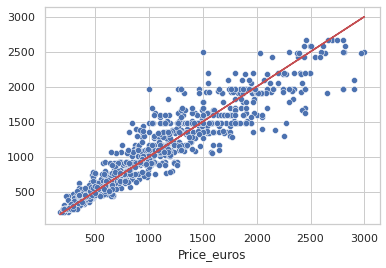

In [36]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [37]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

216.12690380284815

In [38]:
y_test_pred = model.predict(X_test)

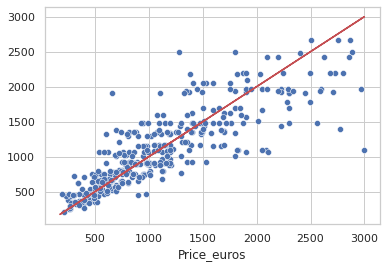

In [39]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [40]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

334.78370967054866

In [41]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

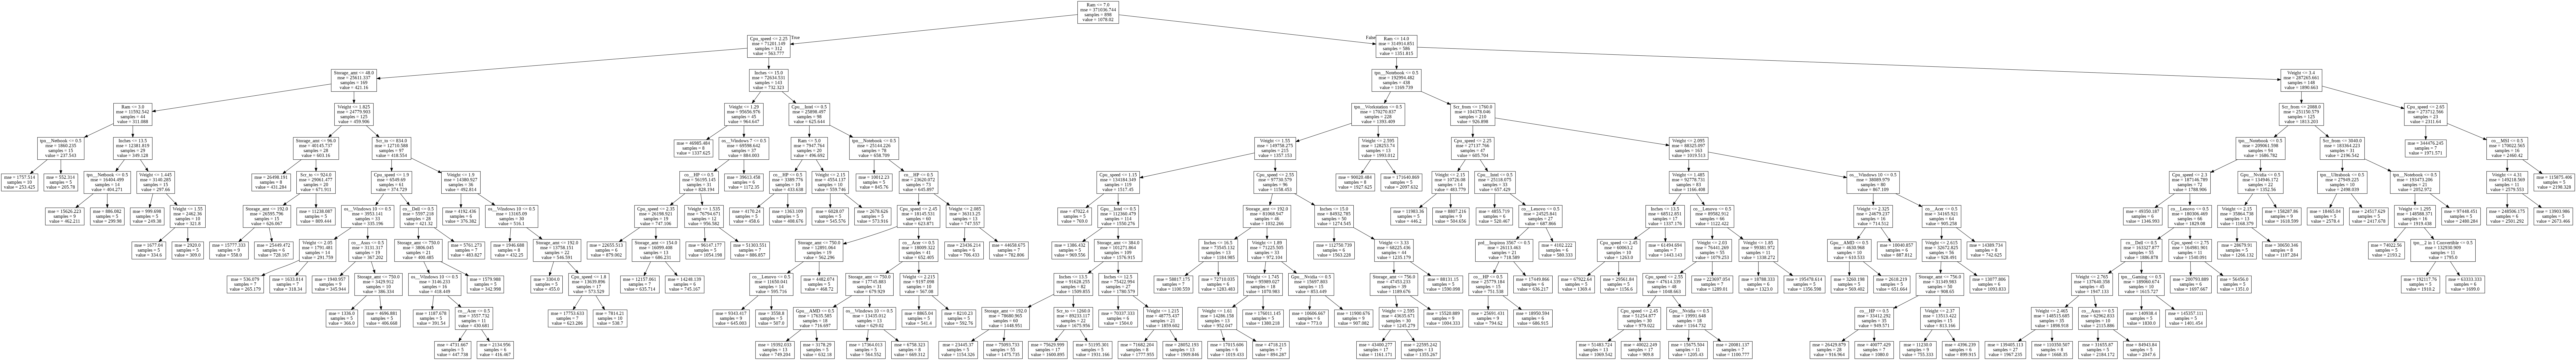

In [42]:
visualize_tree(model, md=100)

# Random Forest Model

In [59]:
# Instantiate model with 1000 decision trees
rf_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf_model.fit(X_train, y_train);

In [62]:
# Use the forest's predict method on the test data
y_train_pred = rf.predict(X_train)

# Calculate the absolute errors
errors = abs(y_train_pred - y_train)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 63.45 degrees.


In [53]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_train)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.9 %.


In [68]:
# Pull out one tree from the forest
tree = rf_model.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

TypeError: ignored

In [69]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Ram                  Importance: 0.54
Variable: Weight               Importance: 0.09
Variable: tpn__Notebook        Importance: 0.09
Variable: Cpu_speed            Importance: 0.06
Variable: Inches               Importance: 0.02
Variable: Storage_amt          Importance: 0.02
Variable: Scr_from             Importance: 0.02
Variable: Scr_to               Importance: 0.02
Variable: tpn__Workstation     Importance: 0.02
Variable: os__Windows 7        Importance: 0.01
Variable: co__Acer             Importance: 0.0
Variable: co__Apple            Importance: 0.0
Variable: co__Asus             Importance: 0.0
Variable: co__Chuwi            Importance: 0.0
Variable: co__Dell             Importance: 0.0
Variable: co__Fujitsu          Importance: 0.0
Variable: co__Google           Importance: 0.0
Variable: co__HP               Importance: 0.0
Variable: co__Huawei           Importance: 0.0
Variable: co__LG               Importance: 0.0
Variable: co__Lenovo           Importance: 0.0
Var

** Predict **

In [56]:
# Use the forest's predict method on the test data
y_test_pred = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(y_test_pred - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 192.38 degrees.


In [57]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.51 %.


In [ ]:
# Pull out one tree from the forest
tree = rf_model.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')